# Battery Simulator
* http://www.206xs.com/topics/battery/iontd2e.pdf
* https://secondlifestorage.com/showthread.php?tid=1855

# Loading battery model

In [1]:
import pandas as pd
df=pd.read_csv('temp.csv',index_col=0)

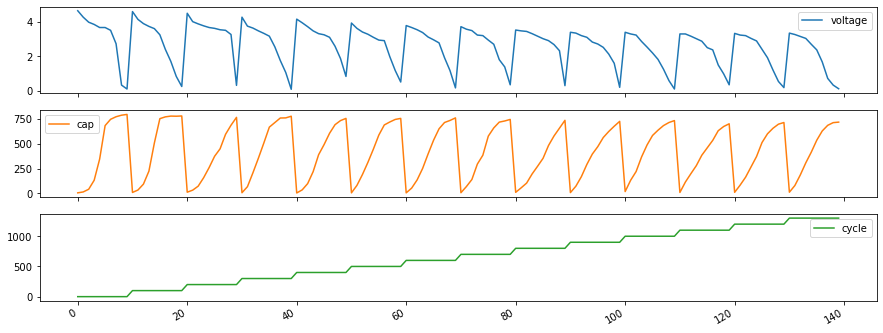

In [2]:
ax=df.plot(subplots=True, figsize=(15,6))

In [3]:
xy=df.to_numpy()

In [4]:
xy.shape

(140, 3)

In [5]:
x=xy[:,1:]
y=xy[:,0]

In [6]:
print(x.shape,y.shape)

(140, 2) (140,)


# Supervised Learning

In [7]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=2, random_state=0)
model.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [8]:
df2=df
yp=model.predict(x)
df2['predict volage']=yp

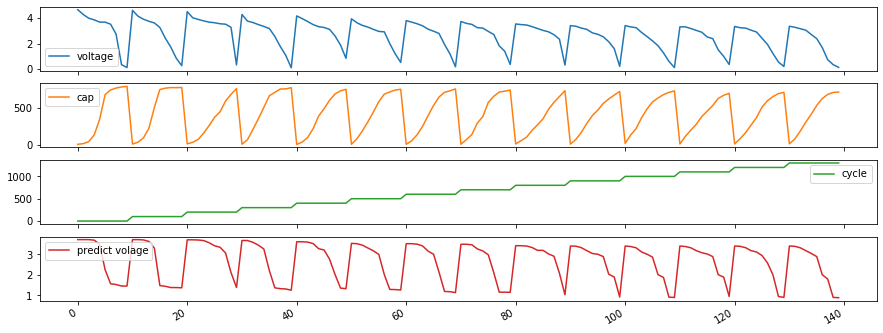

In [9]:
ax=df.plot(subplots=True,figsize=(15,6))

# Verify model

In [10]:
cap=800
cycle=1
voltage=model.predict([[cap,cycle]])
voltage

array([1.45632577])

# Battery and Tester classes

In [11]:
import numpy as np
import datetime as dt
#mah=maxc-c/(0.001*3600)
#c=(maxc-mah)*0.001*3600
def c2mah(cap,maxcap):
    return maxcap-cap/(0.001*3600)
def mah2c(mah,maxcap):
    return (maxcap-mah)*0.001*3600

class Battery(object):
    def __init__(self,model,start):
        
        self.max_cap_heat=300 #specific heat capacity [Joule]
        self.max_cap_elec=800 #800mAh = 800*0.001*3600 [Coulomb]
        self.internal_resistance=1.0
        
        self.current=1.0
        self.ischarge=False
        self.cycle=0  
        
        self.cap=mah2c(0,self.max_cap_elec)
        self.temp=25 #[C]
        self.voltage=4.2 #[V]
        self.model=model
        
    def step(self,dtime): #pos is discharge
        self.internal_resistance=1.0+0.001*self.temp*self.temp
        if self.ischarge==True and self.current>0:
            self.ischarge=False
            self.cycle+=1
            if b.cycle%100==0:
                print(b.cycle)
            
        self.cap=self.cap-dtime*self.current
        
        if self.cap<=0.0:
            self.ischarge=True
            self.current=0.0
        dtemp=self.current*self.current*self.internal_resistance/self.max_cap_heat*dtime
        self.temp=0.9*(self.temp+dtemp)+0.1*(25.0)
        x=[c2mah(self.cap, self.max_cap_elec), self.cycle]
        self.voltage=model.predict([x])[0]
    def get_charge_time(self,chargecurrent):
        return mah2c(0,self.max_cap_elec)/chargecurrent
        

class Tester(object):
    def __init__(self, max_cycle=10, charge_current=0.6, discharge_current=0.4, working_temp=30, delta=60):
        self.chargecurrent=charge_current #A
        self.dischargecurrent=discharge_current
        self.ischarge=False
        self.chargetime=0
        self.max_cycle=max_cycle
        self.working_temp=working_temp
        self.d=delta #second
        self.time=start+dt.timedelta(seconds=self.d)
        self.data={
                        'time':[],
                        'voltage':[],
                        'current':[],
                        'capacity':[],
                        'temp':[],
                        'cycle':[]
                    }
    def step(self,b):
        if self.ischarge==False and b.current<=0.0:
            self.ischarge=True
            #print('to_charge')
        if self.chargetime>=b.get_charge_time(self.chargecurrent):
            self.ischarge=False
            #print('discharge')
        
        if self.ischarge==True:
            b.current=-1*self.chargecurrent+np.random.randn()*0.01
            self.chargetime+=self.d
        else:
            if b.temp>self.working_temp:
                b.current=0.01
            else:
                b.current=self.dischargecurrent+np.random.randn()*0.03
            self.chargetime=0.0
        b.step(self.d)
        
    def run(self):
        while True:
            dtime=np.random.randint(self.d-2,self.d+2)
            self.time+=dt.timedelta(seconds=dtime)
            t.step(b)
            self.data['time'].append(self.time)
            self.data['voltage'].append(b.voltage)
            self.data['current'].append(b.current)
            self.data['capacity'].append(b.cap)
            self.data['temp'].append(b.temp)
            self.data['cycle'].append(b.cycle)
        #     print("b.v:%.2f, b.c%+.1f, b.cap:%+07.1f, charge(b,t):(%s,%s) (%s)"%\
        #           (b.voltage,b.current,b.cap,b.ischarge,t.ischarge,b.temp))
            if b.cycle>t.max_cycle:
                break

        df2=pd.DataFrame(self.data)
        df2.index=pd.to_datetime(df2.time)
        df2=df2.drop(['time'],axis=1)
        return df2

# Run simulation

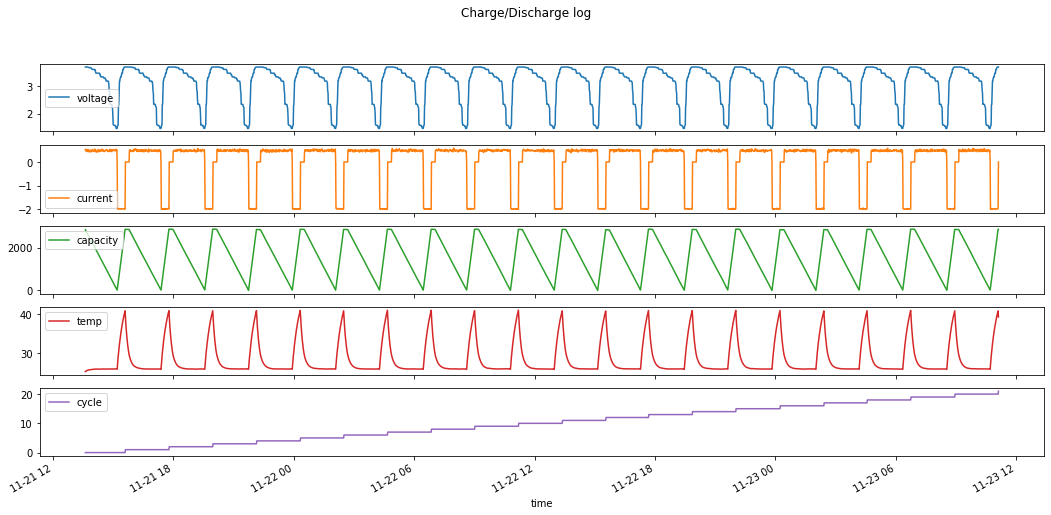

In [12]:
start=dt.datetime.strptime('2019-11-21 13:35:05',"%Y-%m-%d %H:%M:%S")
b=Battery(model,start)
t=Tester(max_cycle=20, charge_current=2.0, discharge_current=0.5, working_temp=30)
df2=t.run()
a=df2.plot(subplots=True, title='Charge/Discharge log', figsize=(18,8))
df2.to_csv('log20.csv')

100
200
300
400
500
600
700
800
900
1000


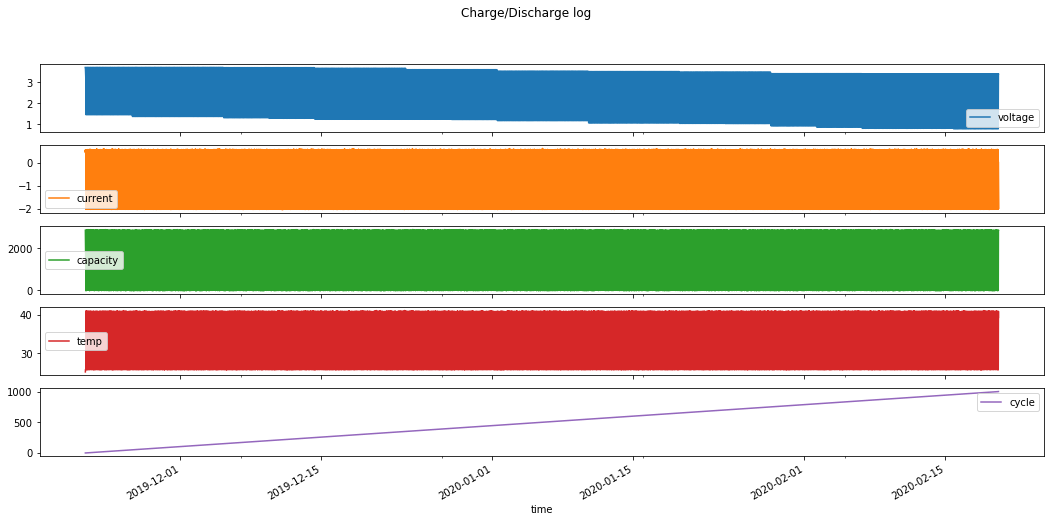

In [13]:
start=dt.datetime.strptime('2019-11-21 13:35:05',"%Y-%m-%d %H:%M:%S")
b=Battery(model,start)
t=Tester(max_cycle=1000, charge_current=2.0, discharge_current=0.5, working_temp=30)
df3=t.run()
a=df3.plot(subplots=True, title='Charge/Discharge log', figsize=(18,8))
df3.to_csv('log1000.csv')